In [1]:
import torch
import torchvision
import numpy as np
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt


## Task 1: Basics

In [2]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 118MB/s]


In [3]:
!unzip TestDataSet.zip

Archive:  TestDataSet.zip
   creating: TestDataSet/
   creating: TestDataSet/n02795169/
  inflating: __MACOSX/TestDataSet/._n02795169  
   creating: TestDataSet/n02769748/
  inflating: __MACOSX/TestDataSet/._n02769748  
   creating: TestDataSet/n02834397/
  inflating: __MACOSX/TestDataSet/._n02834397  
   creating: TestDataSet/n02917067/
  inflating: __MACOSX/TestDataSet/._n02917067  
   creating: TestDataSet/n02808304/
  inflating: __MACOSX/TestDataSet/._n02808304  
   creating: TestDataSet/n03016953/
  inflating: __MACOSX/TestDataSet/._n03016953  
   creating: TestDataSet/n02793495/
  inflating: __MACOSX/TestDataSet/._n02793495  
   creating: TestDataSet/n02814533/
  inflating: __MACOSX/TestDataSet/._n02814533  
   creating: TestDataSet/n02837789/
  inflating: __MACOSX/TestDataSet/._n02837789  
   creating: TestDataSet/n02840245/
  inflating: __MACOSX/TestDataSet/._n02840245  
   creating: TestDataSet/n02992211/
  inflating: __MACOSX/TestDataSet/._n02992211  
   creating: TestDataSet

In [4]:
# preprocess images in TestDataSet
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=5,)

In [5]:
import json

# Open and read the JSON file
with open('./TestDataSet/labels_list.json', 'r') as file:
    labels = json.load(file)

# Print the data
print(labels)

['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary', '411: apron', '412: ashcan', '413: assault rifle', '414: backpack', '415: bakery', '416: balance beam', '417: balloon', '418: ballpoint', '419: Band Aid', '420: banjo', '421: bannister', '422: barbell', '423: barber chair', '424: barbershop', '425: barn', '426: barometer', '427: barrel', '428: barrow', '429: baseball', '430: basketball', '431: bassinet', '432: bassoon', '433: bathing cap', '434: bath towel', '435: bathtub', '436: beach wagon', '437: beacon', '438: beaker', '439: bearskin', '440: beer bottle', '441: beer glass', '442: bell cote', '443: bib', '444: bicycle-built-for-two', '445: bikini', '446: binder', '447: binoculars', '448: birdhouse', '449: boathouse', '450: bobsled', '451: bolo tie', '452: bonnet', '453: bookcase', '454: bookshop', '455: bottlecap', '456: bow', '457: bow tie', '458: 

In [6]:
def get_accuracies(model, data_loader): #gets the outputs of a trained model when it sees the data within data_loader. gets the top1 and top5 accuracy as per the project description
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  correct_samples = 0
  top5_correct_samples = 0
  num_samples = 0
  accuracy = 0
  top5_acc = 0

  for step, (images, targets) in enumerate(data_loader):
    model.eval()
    images, targets = images.to(device), targets.to(device)
    with torch.no_grad():
      outputs = model(images)
    correct_label = int(labels[step][:3])
    # calculate top1 accuracy
    _, preds = torch.max(outputs, dim=1)
    correct_samples += preds.eq(correct_label).sum().item()
    # calulate top5 accuracy
    top5_preds = torch.topk(outputs, 5).indices
    top5_correct_samples += torch.isin(top5_preds, correct_label).sum().item()
    num_samples += images.size(0)

  accuracy = 100.0 * correct_samples / num_samples
  top5_acc = 100.0 * top5_correct_samples / num_samples
  print(f"top1 accuracy: {accuracy:.2f}%")
  print(f"top5 accuracy: {top5_acc:.2f}%")
  return accuracy, top5_acc




In [ ]:
acc, top5acc = get_accuracies(pretrained_model, data_loader) #gets accuracy of the pretrained model on the base data.

top1 accuracy: 76.00%
top5 accuracy: 94.20%


## Task 2: Pixel-Wise Attacks

In [7]:
# # https://www.kaggle.com/code/haxothermic/fgsm-against-resnet-50-on-cifar-10, modified slightly


def fgsm_attack(model, criterion, images, labels, device, epsilon=0.02):
  model = model.to(device) #put model on gpu if needed
  model.eval()

  original_images = images.clone().detach()

  images.requires_grad_(True)

  outputs = model(images)

  loss = criterion(outputs, labels)
  model.zero_grad()
  loss.backward()

  sign_data_grad = torch.sign(images.grad.data)

  perturbed_images = images + epsilon * sign_data_grad

  # ensure L_inf <= epsilon. This will throw an error if l_inf > epsilon
  l_inf = torch.max(torch.abs(perturbed_images - original_images)).item()
  assert l_inf <= epsilon + 1e-6, f"Attack failed: max L∞ distance {l_inf} exceeds {epsilon}"

  perturbed_images = torch.clamp(perturbed_images, 0, 1)

  return perturbed_images, sign_data_grad


In [8]:
def show_img(images, adversarial_images, adversarial_outputs, toCPU=False): #displays the original and adversarial image with a bar chart showing the top classification guesses
#toCPU is there because the location of these variables are not very well tracked throughout the code so there were some issues with this. used claude to help visualize.

  pred_num, top5_preds = torch.topk(adversarial_outputs, 5)
  for idx in range(len(images)):
    if 401 not in top5_preds[idx]:
      plt.figure()
      f, axis = plt.subplots(1,3, figsize=(8, 4))
      axis[0].imshow(images[idx].cpu().T.data.numpy())
      axis[0].set_title("Original")
      axis[1].imshow(adversarial_images[idx].cpu().T.data.numpy())
      axis[1].set_title("Adversarial")
      if toCPU:
        axis[2].bar(["".join(item) for item in top5_preds[idx].detach().cpu().numpy().astype(str)], pred_num[idx].detach().cpu().numpy())
      else:
        axis[2].bar(["".join(item) for item in top5_preds[idx].detach().numpy().astype(str)], pred_num[idx].detach().numpy())
      axis[2].set_title("Predictions")
      plt.show()

<ipython-input-8-76132620de51>:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  axis[0].imshow(images[idx].cpu().T.data.numpy())


<Figure size 640x480 with 0 Axes>

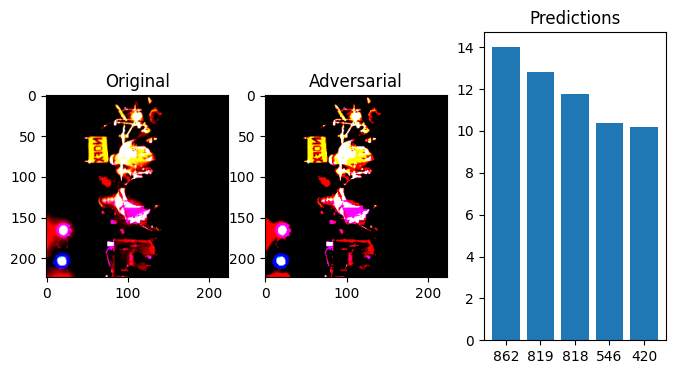

<Figure size 640x480 with 0 Axes>

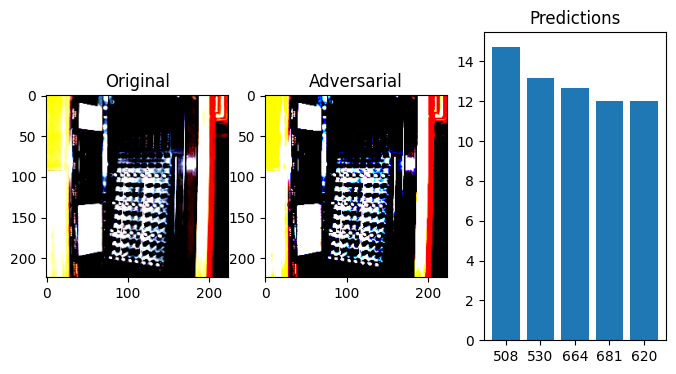

<Figure size 640x480 with 0 Axes>

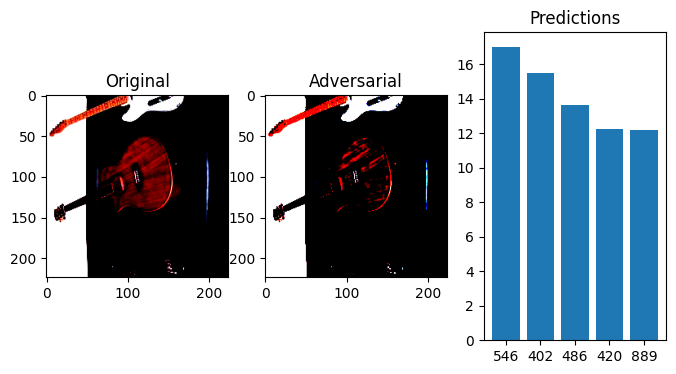

<Figure size 640x480 with 0 Axes>

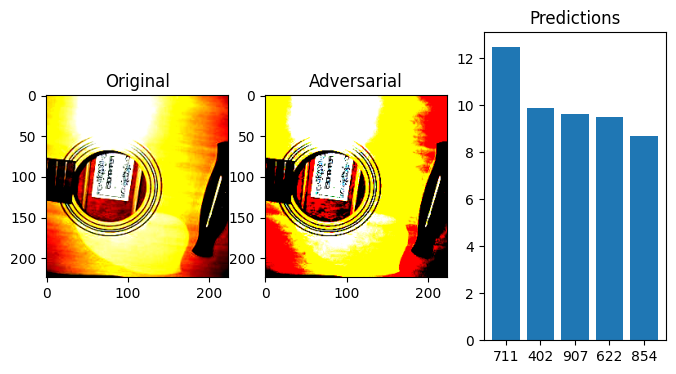

<Figure size 640x480 with 0 Axes>

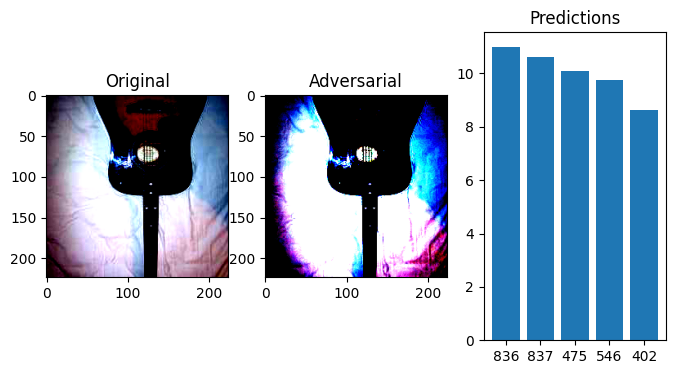

<Figure size 640x480 with 0 Axes>

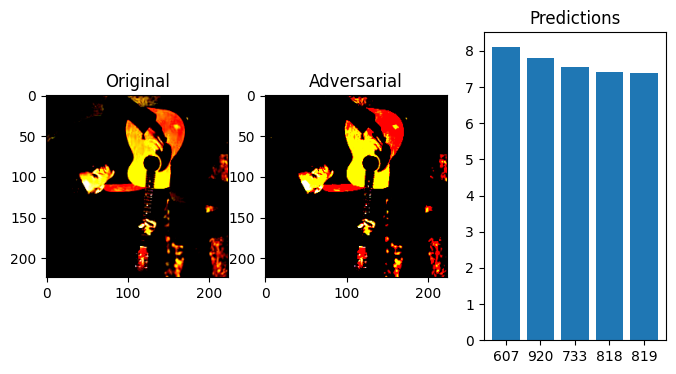

<Figure size 640x480 with 0 Axes>

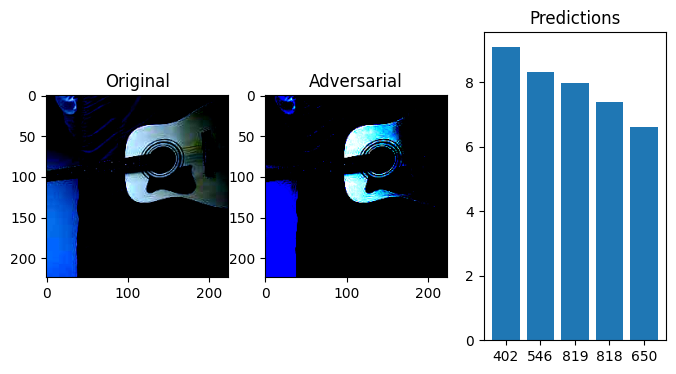

<Figure size 640x480 with 0 Axes>

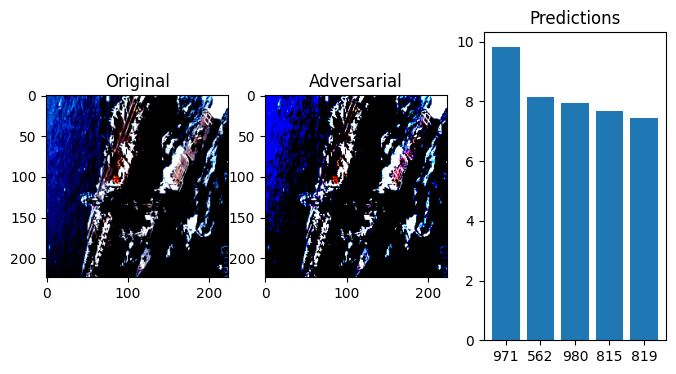

<Figure size 640x480 with 0 Axes>

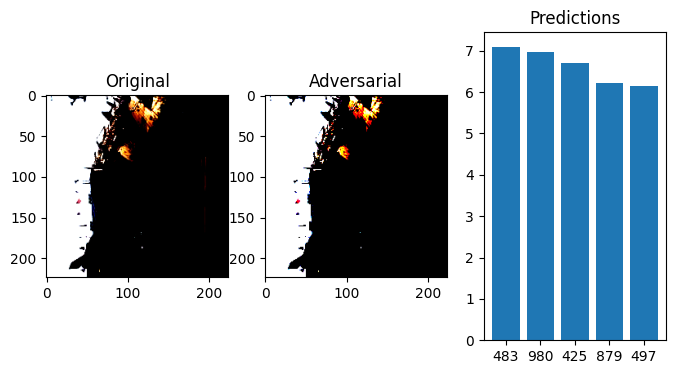

<Figure size 640x480 with 0 Axes>

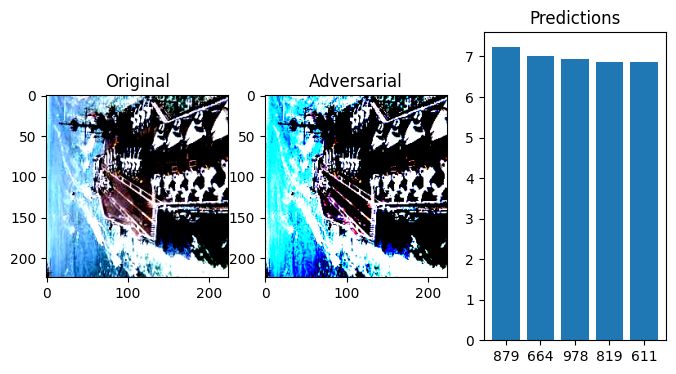

<Figure size 640x480 with 0 Axes>

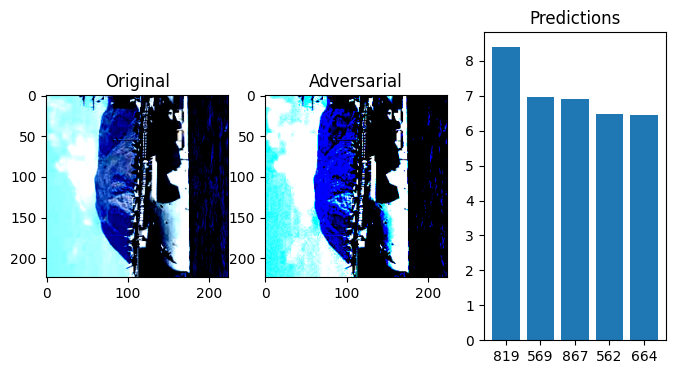

<Figure size 640x480 with 0 Axes>

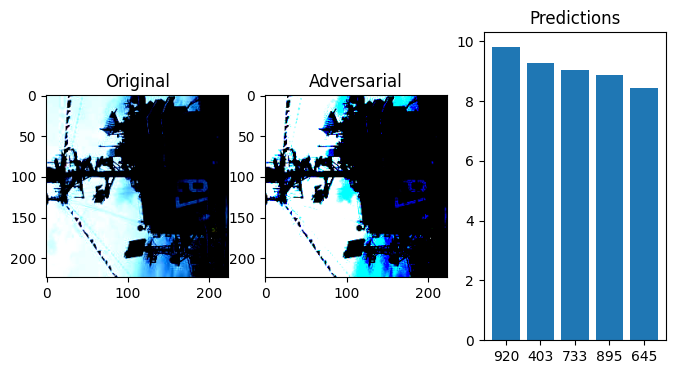

In [9]:
# create adversarial images and save as a dataset
criterion = nn.CrossEntropyLoss()
epsilon = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AdversarialTestSet1 = [[] for _ in range(5*len(data_loader))]

for step, (images, targets) in enumerate(data_loader):
    images, targets = images.to(device), targets.to(device)  # move to GPU

    adversarial_images, _ = fgsm_attack(pretrained_model, criterion, images, torch.tensor([int(labels[step][:3]) for _ in range(5)]), device, epsilon)

    for idx in range(len(adversarial_images)):
        adv_img_pil = transforms.functional.to_pil_image(adversarial_images[idx].cpu())  # move to CPU for transforms
        adversarial_images[idx] = plain_transforms(adv_img_pil)
        AdversarialTestSet1[step*5+idx].append(adversarial_images[idx])
        AdversarialTestSet1[step*5+idx].append(targets[idx].cpu())  # move to CPU for storage or further use

    adversarial_outputs = pretrained_model(adversarial_images.to(device))  # move adversarial_images to GPU if needed

    if step < 3 :
        show_img(images.cpu(), adversarial_images.cpu(), adversarial_outputs.cpu())




In [10]:
adv_data_loader = torch.utils.data.DataLoader(AdversarialTestSet1, batch_size=5,)

In [11]:
adv1_acc, adv1_top5acc = get_accuracies(pretrained_model, adv_data_loader) #tests the pretrained model on the first adversarial data (fgsm)


top1 accuracy: 26.20%
top5 accuracy: 51.20%


## Task 3: Improved Attacks

In [ ]:

def improved_attack(model, criterion, images, labels, device, target_class, epsilon=0.02, alpha=0.002, iterations=10): #this does a targetted attack on the target_class
    model.eval()

    images = images.to(device) #puts everything on gpu if needed
    labels = labels.to(device)

    original_images = images.clone().detach()
    perturbed_images = original_images.clone().detach()

    for i in range(iterations): #do this an iteration number of times, the larger the iterations the stronger the attack
        perturbed_images.requires_grad_(True)
        outputs = model(perturbed_images)

        targeted_labels = torch.full_like(labels, target_class)
        loss = criterion(outputs, targeted_labels)
        loss = -loss

        model.zero_grad() #similar pertubation as the fgsm
        loss.backward()
        grad_sign = torch.sign(perturbed_images.grad.data)

        perturbed_images = perturbed_images.detach() + alpha * grad_sign

        delta = torch.clamp(perturbed_images - original_images, -epsilon, epsilon)
        perturbed_images = torch.clamp(original_images + delta, -2.1179, 2.6400).detach() #clamp over the range of the images, which is -2.1 to 2.6

        perturbation = perturbed_images - original_images

    perturbation = perturbed_images - original_images
    l_inf = torch.max(torch.abs(perturbation)).item()
    if l_inf > epsilon + 1e-6: #ensures that l_inf <= epsilon
        print(f"WARNING: Final L∞ distance {l_inf:.6f} exceeds epsilon {epsilon}")

    return perturbed_images, perturbation




<Figure size 640x480 with 0 Axes>

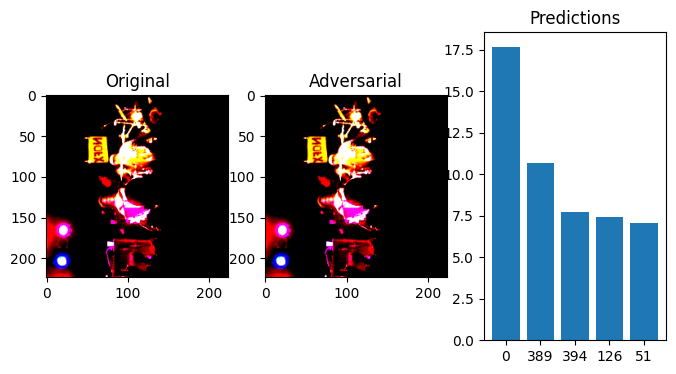

<Figure size 640x480 with 0 Axes>

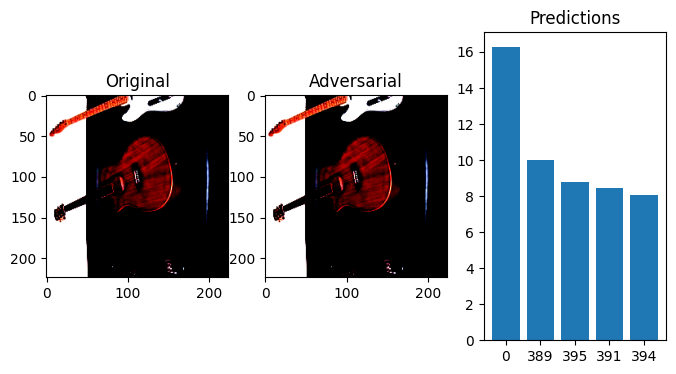

<Figure size 640x480 with 0 Axes>

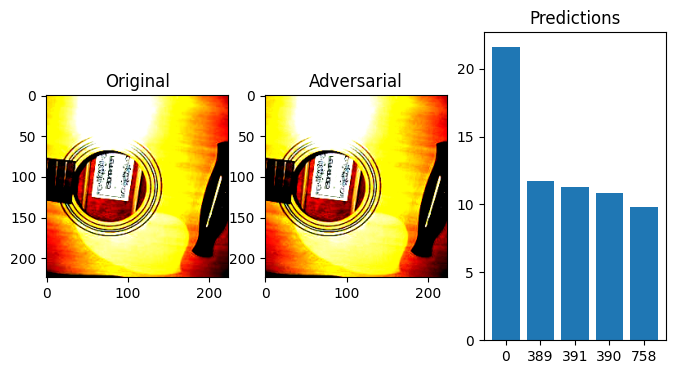

<Figure size 640x480 with 0 Axes>

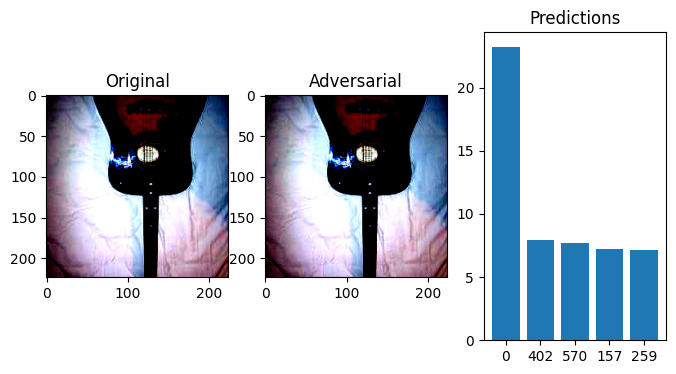

<Figure size 640x480 with 0 Axes>

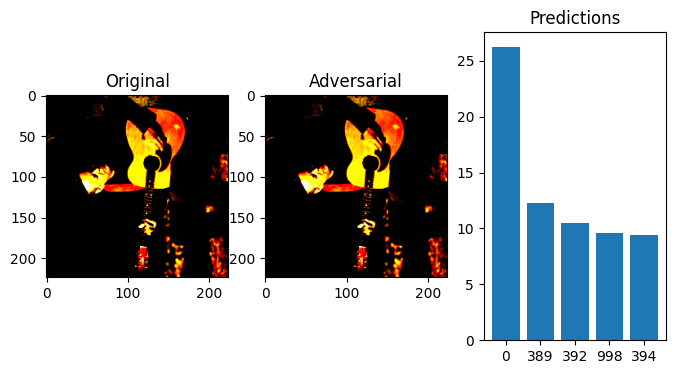

<Figure size 640x480 with 0 Axes>

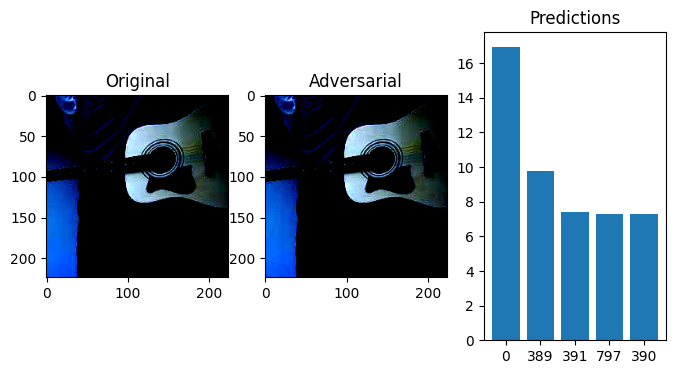

<Figure size 640x480 with 0 Axes>

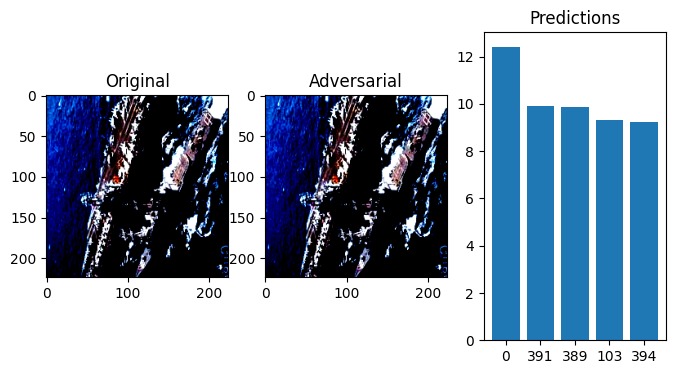

<Figure size 640x480 with 0 Axes>

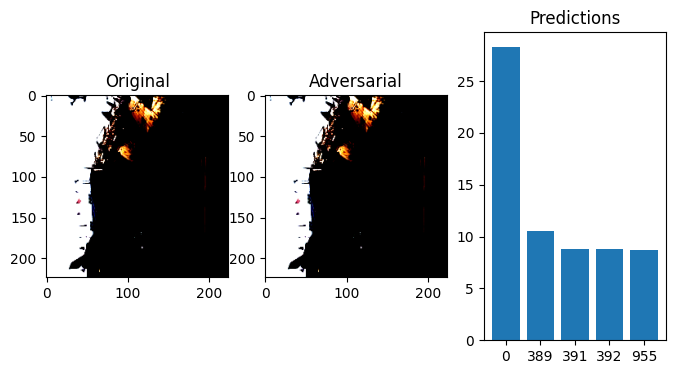

<Figure size 640x480 with 0 Axes>

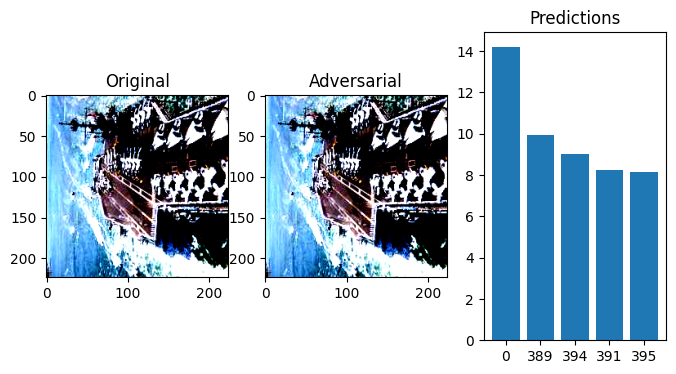

<Figure size 640x480 with 0 Axes>

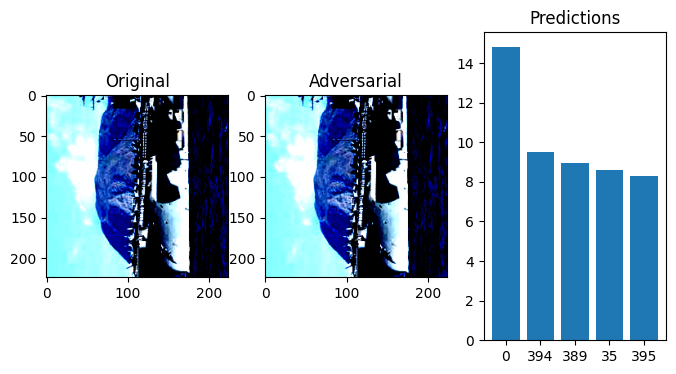

<Figure size 640x480 with 0 Axes>

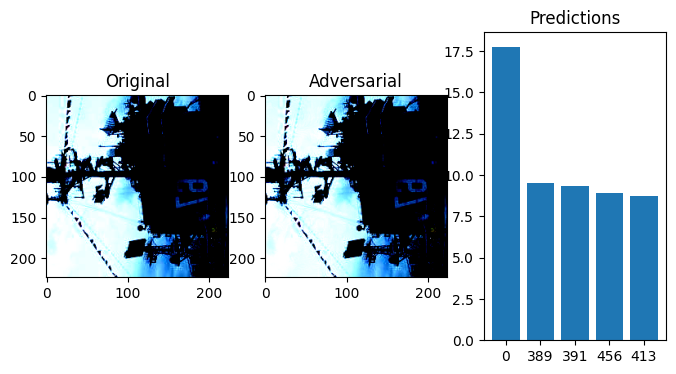

In [ ]:
criterion = nn.CrossEntropyLoss()
epsilon = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_correct = 0
attack_success = 0
total = 0
pretrained_model = pretrained_model.to(device)



adv2_images_list = [] #keep these to create the data loader
adv2_labels_list = []

# which target class to target in the attack
target_class = 0

for step, (images, targets) in enumerate(data_loader):
    images, targets = images.to(device), targets.to(device)

    improved_adversarial_images, improved_perturbation = improved_attack( #do the targetted attack on the images on the target_class. do 30 iterations to get the accuracy sufficiently low
        pretrained_model,
        criterion,
        images,
        targets,
        device,
        target_class,
        epsilon=epsilon,
        alpha=0.002,
        iterations=30
    )

    # store adversarial images and labels
    adv2_images_list.append(improved_adversarial_images.cpu())
    adv2_labels_list.append(targets.cpu())

    # get model predictions for show_img
    if step < 3 :
      with torch.no_grad():
        improved_adversarial_outputs = pretrained_model(improved_adversarial_images)
        show_img(images, improved_adversarial_images, improved_adversarial_outputs, True)

adv2_images_tensor = torch.cat(adv2_images_list, dim=0)
adv2_labels_tensor = torch.cat(adv2_labels_list, dim=0)

AdversarialTestSet2 = torch.utils.data.TensorDataset(adv2_images_tensor, adv2_labels_tensor)
adv2_data_loader = torch.utils.data.DataLoader(AdversarialTestSet2, batch_size=5, shuffle=False)


In [ ]:
adv2_acc, adv2_top5acc = get_accuracies(pretrained_model, adv2_data_loader) #tests how the pretrained model does on the target attack

top1 accuracy: 4.40%
top5 accuracy: 23.00%


## Task 4: Patch Attacks

In [ ]:
def patch_attack(model, criterion, images, labels, device, target_class, patch_size=32, epsilon=0.02, alpha=0.002, iterations=10): #perturbes only a patch of the images of the target_class

    model.eval()

    images = images.to(device)
    labels = labels.to(device)

    original_images = images.clone().detach()
    perturbed_images = original_images.clone().detach()

    batch_size, channels, height, width = images.shape

    top_lefts = []
    for _ in range(batch_size): #gets the random patches (it gets the top left, since we know the patch size we only need this point)
        max_top = height - patch_size
        max_left = width - patch_size

        top = torch.randint(0, max_top + 1, (1,)).item()
        left = torch.randint(0, max_left + 1, (1,)).item()
        top_lefts.append((top, left))

    # create a mask that can be modified so we know what the pixel modifications are
    mask = torch.zeros_like(images)

    for i, (top, left) in enumerate(top_lefts):
        mask[i, :, top:top+patch_size, left:left+patch_size] = 1.0

    for i in range(iterations):
        perturbed_images.requires_grad_(True)
        outputs = model(perturbed_images)

        targeted_labels = torch.full_like(labels, target_class) #only those with the target_class
        loss = criterion(outputs, targeted_labels)
        loss = -loss #misdirect the model

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            grad_sign = torch.sign(perturbed_images.grad.data)
            masked_grad_sign = grad_sign * mask

            # update only the patch area, this is the attack
            perturbed_images = perturbed_images.detach() + alpha * masked_grad_sign

            # clamp within epsilon
            delta = torch.clamp(perturbed_images - original_images, -epsilon, epsilon)

            perturbed_images = original_images + delta * mask

            # clamp within the range of the image -2.1 to 2.6
            perturbed_images = torch.clamp(perturbed_images, -2.1179, 2.6400).detach()

    perturbation = perturbed_images - original_images

    # ensure l_inf remains within bounds
    patch_perturbations = []
    for i, (top, left) in enumerate(top_lefts):
        patch_pert = perturbation[i, :, top:top+patch_size, left:left+patch_size]
        patch_perturbations.append(torch.max(torch.abs(patch_pert)).item())

    l_inf = max(patch_perturbations)

    if l_inf > epsilon + 1e-6:
        print(f"WARNING: Final L∞ distance {l_inf:.6f} exceeds epsilon {epsilon}")

    return perturbed_images, perturbation, mask  # Return mask for visualization if needed


<Figure size 640x480 with 0 Axes>

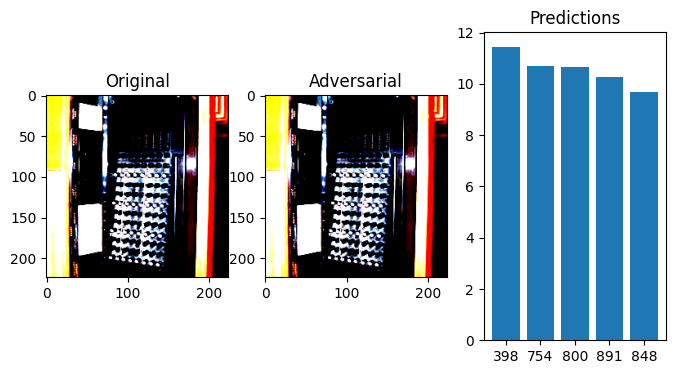

<Figure size 640x480 with 0 Axes>

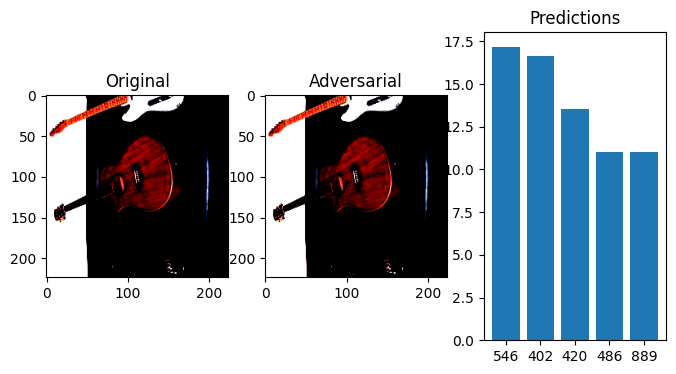

<Figure size 640x480 with 0 Axes>

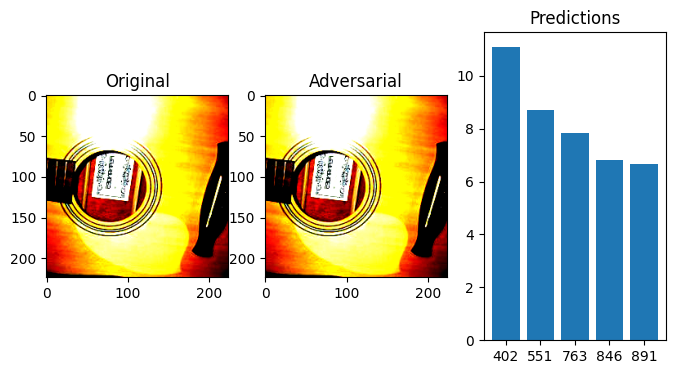

<Figure size 640x480 with 0 Axes>

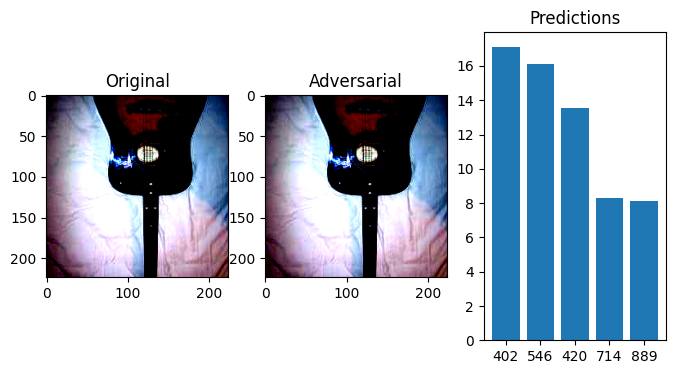

<Figure size 640x480 with 0 Axes>

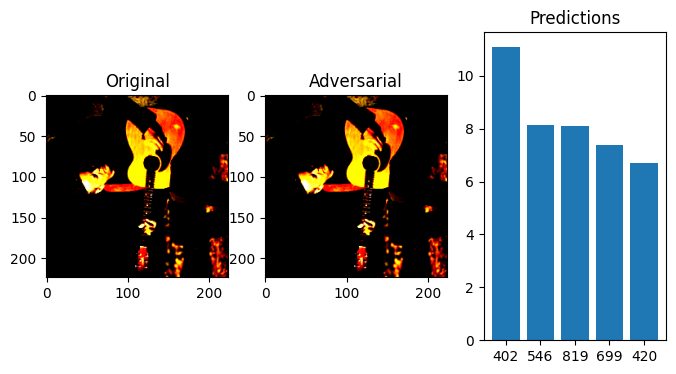

<Figure size 640x480 with 0 Axes>

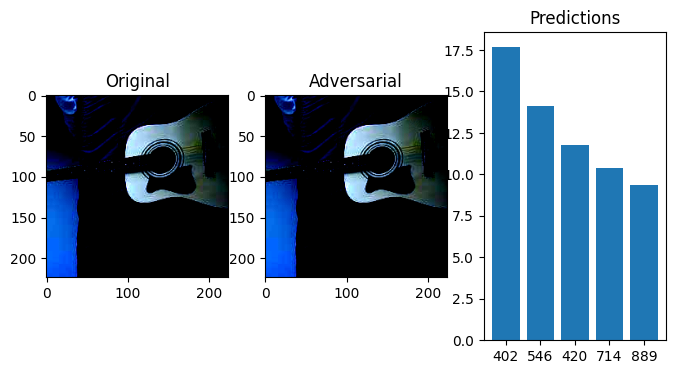

<Figure size 640x480 with 0 Axes>

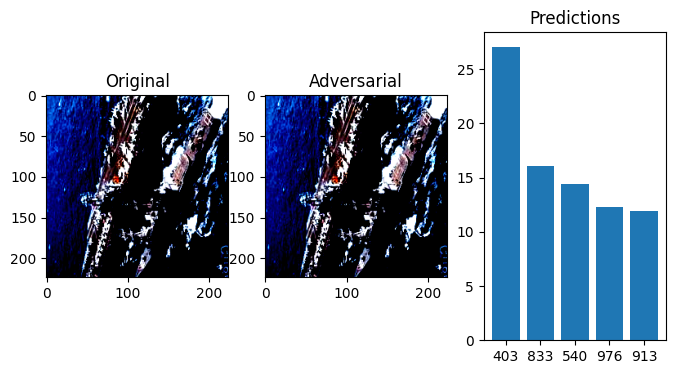

<Figure size 640x480 with 0 Axes>

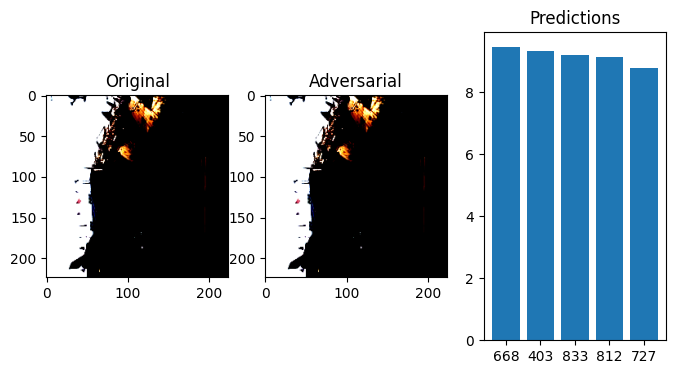

<Figure size 640x480 with 0 Axes>

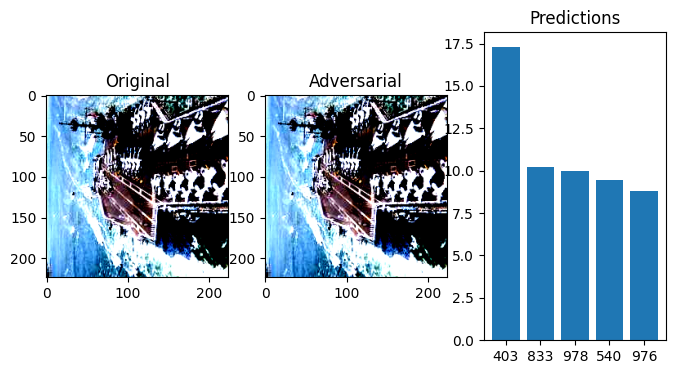

<Figure size 640x480 with 0 Axes>

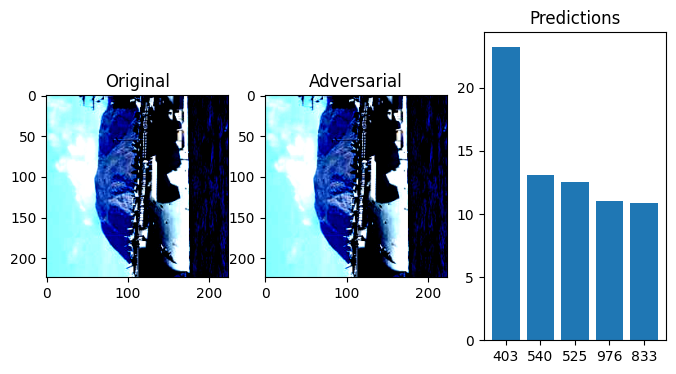

<Figure size 640x480 with 0 Axes>

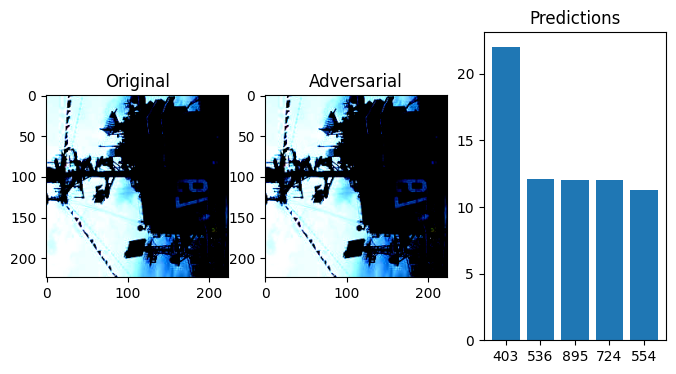

In [ ]:

criterion = nn.CrossEntropyLoss()
epsilon = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_correct = 0
attack_success = 0
total = 0
pretrained_model = pretrained_model.to(device)

adv3_images_list = [] #store these for the data loader later on
adv3_labels_list = []

# Target class for the attack
target_class = 0
patch_size = 32

for step, (images, targets) in enumerate(data_loader):
    images, targets = images.to(device), targets.to(device)

    adv3_images, adv3_perturbation, adv3_mask = patch_attack( #do the patch attack on target class 0.
        pretrained_model,
        criterion,
        images,
        targets,
        device,
        target_class,
        patch_size=patch_size,
        epsilon=epsilon,
        alpha=0.002,
        iterations=30
    )

    adv3_images_list.append(adv3_images.cpu())
    adv3_labels_list.append(targets.cpu())



    if step < 3 :
      with torch.no_grad():
        adv3_outputs = pretrained_model(adv3_images) #for show_img.
        show_img(images, adv3_images, adv3_outputs, True)

In [ ]:
adv3_images_tensor = torch.cat(adv3_images_list, dim=0)
adv3_labels_tensor = torch.cat(adv3_labels_list, dim=0)

AdversarialTestSet3 = torch.utils.data.TensorDataset(adv3_images_tensor, adv3_labels_tensor)
adv3_data_loader = torch.utils.data.DataLoader(AdversarialTestSet3, batch_size=64, shuffle=False)



In [ ]:
adv3_acc, adv3_top5acc = get_accuracies(pretrained_model, adv3_data_loader) #tests on this new patch attack dataset

top1 accuracy: 0.60%
top5 accuracy: 1.20%


## Task 5: Transferring Attacks

In [ ]:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')

In [ ]:
adv_acc_new, adv_top5acc_new = get_accuracies(new_model, adv_data_loader) #tests the fgsm adversarial dataset

top1 accuracy: 48.20%
top5 accuracy: 71.00%


In [ ]:
adv_acc_new2, adv_top5acc_new2 = get_accuracies(new_model, adv2_data_loader) #tests the targetting adversarial dataset

top1 accuracy: 73.20%
top5 accuracy: 92.60%


In [ ]:
adv_acc_new3, adv_top5acc_new3 = get_accuracies(new_model, adv3_data_loader) #tests the patch dataset

top1 accuracy: 0.60%
top5 accuracy: 1.20%
